# DSME Bonus Point Assignment II Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.1, released 2021-02-17</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [1]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm


# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Question B1 - Deep Q-Networks
### a) Implement Replay Buffer

In [2]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    def is_filled(self):
        """Check if the memory is filled."""
        return buffer.mem_cntr >= buffer.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        # TODO
        index = self.mem_cntr % self.mem_size #hint: using modulo-division to compute the index
        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = is_terminal
        self.mem_cntr += 1


    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        # TODO
        max_mem = min(self.mem_cntr, self.mem_size) 
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        is_terminal = self.terminal_memory[batch]
        
        return states, actions, rewards, next_states, is_terminal

In [3]:
# Test code
_buffer = ReplayBuffer(10, (5,))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10): # Fill test values
    _buffer.add(np.arange(5)+i , 5+i, 6+i, 7+np.arange(5)+i, (12+i)%2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5)+i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5+i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6+i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7+np.arange(5)+i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12+i)%2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

'ok'

### b) Fill replay buffer

_Changed 2021-02-17: Renamed `max_size` parameter to `mem_size`_

In [4]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)

# ********************
# TODO Sampled transitions from environment and add to buffer

while buffer.is_filled() == False:
    state = env.reset()
    action = env.action_space.sample()
    next_state, reward, is_terminal, _ = env.step(action)
    buffer.add(state, action, reward, next_state, is_terminal)


In [5]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Question B2 - Deep Q-Networks
### a) Define Q-Network

In [12]:
import torch
from torch import nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # TODO Create layers
        self.fc1 = nn.Linear(4,256)
        self.fc2 = nn.Linear(256,2)


    def forward(self, state):
        # TODO Implement forward pass
        state = F.relu(self.fc1(state))
        Q = F.relu(self.fc2(state))

        return Q

In [13]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [14]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # TODO Epsilon-greedy action sampling
    state = torch.FloatTensor(state)
    
    if np.random.random_sample() <= epsilon: #---> explore 
        action = env.action_space.sample()
    else:
        action = q_network(state).argmax().item()
        
    return action

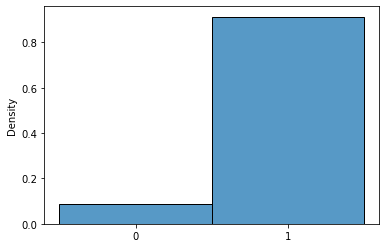

In [15]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1,2]) # Constant output

# Sample 1000 actions
_actions = [epsilon_greedy([1,2,3,4], DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0,1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

_Changed 2021-02-17: Added `gamma` explicitely to parameters_

In [16]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma = 0.99):
    # TODO Implement loss function
    qvals = torch.gather(q_network.forward(states), 1, actions)
    
    next_actions = torch.argmax(q_network.forward(next_states), dim = 1, keepdim = True)
    
    qvals_next = torch.gather(target_network.forward(next_states), 1, next_actions).detach()
    
    qvals_next[is_terminal] = 0
    
    expected_qvals = gamma * qvals_next + rewards

    loss = mse(qvals, expected_qvals)
    return loss

### d) Training
_Changed 2021-02-19: Properly call `compute_loss`_

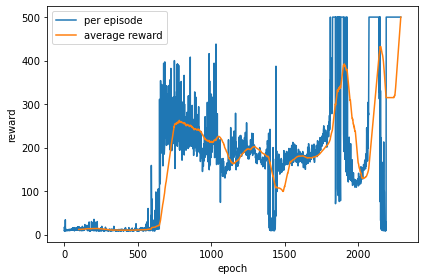

In [17]:
# Hyperparameters
epsilon = 0.1  # For epsilon greedy action sampling
batch_size = 128
NETWORK_UPDATE_FREQUENCY = 4
NETWORK_SYNC_FREQUENCY = 2000
gamma = 0.99
episodes = 2500
replay_buffer_size = 0 #TODO


q_network = DeepQNetwork()
target_network = deepcopy(q_network)
optimizer = torch.optim.Adam(q_network.parameters(), lr=0.001)
mse = nn.MSELoss()

step_count = 0
total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        state, done = env.reset(), False
        rewards = []

        while not done:
            # Take a step
            action = epsilon_greedy(state, q_network, epsilon=epsilon)
            next_state, reward, done, _ = env.step(action)

            # Bookkeeping
            rewards.append(reward)
            buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and env._elapsed_steps < 500)
            state = next_state

            step_count += 1

            # Update network every NETWORK_UPDATE_FREQUENCY steps
            if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                # Sample batch of transitions
                state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                state_batch = torch.FloatTensor(state_batch)
                next_state_batch = torch.FloatTensor(next_state_batch)
                action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                terminal_batch = torch.BoolTensor(terminal_batch)

                # Compute loss
                loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
           
            # Sync networks every NETWORK_SYNC_FREQUENCY steps
            if step_count % NETWORK_SYNC_FREQUENCY == 0:
                # ********************
                # TODO Synchronize networks
                target_network = deepcopy(q_network)

                # ********************

        total_rewards.append(sum(rewards))

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")
        if np.mean(total_rewards[-100:]) == 500:
            break # Stop training

# Save model
with open("solution/b2d.pt", "wb") as f:
    torch.save(q_network, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b2d.png")

In [18]:
# Test code
policy = q_network
policy.eval() # Switch to evaluation mode

def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps
        
_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

'ok (Average reward 500.00)'

## Question 3 - Evaluation

Please write down your answer below.

DQN (Deep Q Network) is like taking some random actions and learning from them through the Q value function and it’s a regression problem (mse loss is used) where two networks are used for training. Whereas, PG (Policy Gradient) is like learning the optimal behavior directly from the experiences (no value function) and it’s a classification problem( maximum log likelihood is used with a some minor change). 

There are four reasons why Policy Gradients are better for Cartpole Problem:

1. Policy methods directly optimize what we care about: our behavior. Valuemethods, such as DQN, do the same indirectly, learning the value first and providing us with the policy based on this value. But, Policy methods are on-policy and require fresh samples from the environment. Value methods can benefit from old data, obtained from the old policy, human demonstration, and other sources. Owing to our Cartpole environment, it is much easier to produce fresh samples and train our policy rather than wasting memory to save old data. 

2. Also, Policy methods are usually less sample-efficient, which means they require more interaction with the environment. Value methods can benefit from large replay buffers. However, sample efficiency doesn't mean that value methods are more computationally efficient, and very often, it's the opposite. As you have seen, both need one hidden layer but we need more number of nodes to approximate the value function than to find the action probabilities. This answers the changes in the NN architecture required.

3. During the training, we needed to access our NN only once, to get the probabilities of actions. In DQN, we need to process two batches of states: one for the current state and another for the next state in the Bellman update.  

4. Value approximators are quite unstable and may lead to huge changes in the Q-values due to small pertubations in the learned weights whereas there will be very less deviation to small pertubations in the learned weights. 